In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import tensorflow as tf

In [2]:
from keras_vggface.vggface import VGGFace
model = VGGFace(model='resnet50')

In [3]:
model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/7x7_s2 (Conv2D)       (None, 112, 112, 64)         9408      ['input_1[0][0]']             
                                                                                                  
 conv1/7x7_s2/bn (BatchNorm  (None, 112, 112, 64)         256       ['conv1/7x7_s2[0][0]']        
 alization)                                                                                       
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['conv1/7x7_s2/

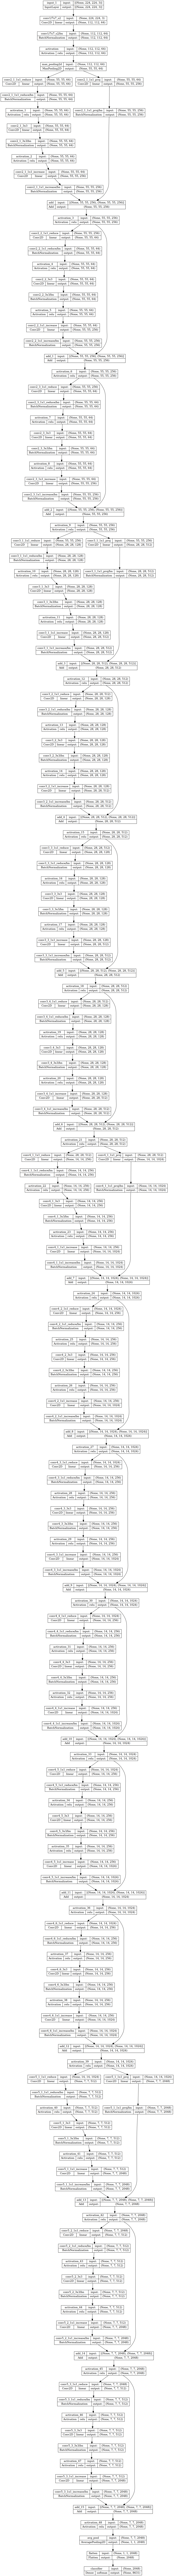

In [4]:
from tensorflow.keras.utils import plot_model

# plot model and display image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_activations=True)

In [5]:
import tf2onnx

spec = tf.TensorSpec([1, 224, 224, 3], tf.float32, name="input_0")

for i in list(range(1, 5))+[len(model.layers)-1]:
    model_i = tf.keras.Model(inputs=model.inputs, outputs=model.layers[i].output, name=f"model_{i}")
    tf2onnx.convert.from_keras(
        model_i,
        input_signature=[spec],
        inputs_as_nchw=['input_0'],
        opset=18,
        output_path=f'model_{i}/model.onnx'
    )

In [6]:
from tensorflow.keras.preprocessing import image
from keras_vggface import utils
import numpy as np
import json

img = image.load_img('../ajb.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2)


input_json = {
    "input_data": [x.flatten().tolist()]
}

# write to ezkl_input.json
with open('ezkl_input.json', 'w') as f:
    json.dump(input_json, f)